**Table of contents**<a id='toc0_'></a>    
- 1. [Preface   ](#toc1_)    
- 2. [Load datasets  ](#toc2_)    
  - 2.1. [Load JMA catalog  ](#toc2_1_)    
    - 2.1.1. [Zoom in Nankai/Tonankai/Tokai  ](#toc2_1_1_)    
  - 2.2. [World tremor database ](#toc2_2_)    
  - 2.3. [Shikoku LFEs](#toc2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Nankai overview    [&#128285;](#toc0_)

In [7]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load datasets   [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Load JMA catalog   [&#128285;](#toc0_)

In [8]:
# Load JMA catalog
path = workdir + 'projects/data/Catalogs/JMA/jma_hypo_2000_2021.dat'

# Read catalog
cshift = 1  # use 1-indexing to better read the column using the guide at https://www.data.jma.go.jp/svd/eqev/data/bulletin/data/format/hypfmt_e.html

record_type_id = []
year = []
month = []
day = []
hour = []
minute = []
second = []
std_err_t = []
lat_deg = []
lat_min = []
std_err_lat = []
lon_deg = []
lon_min = []
std_err_lon = []
depth = []
std_err_depth = []
mag1 = []
mag1_type = []
mag2 = []
mag2_type = []
trav_t_table = []
hypo_loc_prec = []
sub_info = []
max_int = []
dam_class = []
tsun_class = []
distr_nb = []
reg_nb = []
reg_name = []
nb_st = []
hyp_det_flag = []


with open(path, 'r') as f:
    lines = f.readlines()
    for l in lines:
        # Read the line
        record_type_id.append(l[1 - cshift])
        year.append(l[2 - cshift:6 - cshift])
        month.append(l[6 - cshift:8 - cshift])
        day.append(l[8 - cshift:10 - cshift])
        hour.append(l[10 - cshift:12 - cshift])
        minute.append(l[12 - cshift:14 - cshift])
        second.append(l[14 - cshift:18 - cshift])
        std_err_t.append(l[18 - cshift:22 - cshift])
        lat_deg.append(l[22 - cshift:25 - cshift])
        lat_min.append(l[25 - cshift:29 - cshift])
        std_err_lat.append(l[29 - cshift:33 - cshift])
        lon_deg.append(l[33 - cshift:37 - cshift])
        lon_min.append(l[37 - cshift:41 - cshift])
        std_err_lon.append(l[41 - cshift:45 - cshift])
        depth.append(l[45 - cshift:50 - cshift])
        std_err_depth.append(l[50 - cshift:53 - cshift])
        mag1.append(l[53 - cshift:55 - cshift])
        mag1_type.append(l[55 - cshift])
        mag2.append(l[56 - cshift:58 - cshift])
        mag2_type.append(l[58 - cshift])
        trav_t_table.append(l[59 - cshift])
        hypo_loc_prec.append(l[60 - cshift])
        sub_info.append(l[61 - cshift])
        max_int.append(l[62 - cshift])
        dam_class.append(l[63 - cshift])
        tsun_class.append(l[64 - cshift])
        distr_nb.append(l[65 - cshift])
        reg_nb.append(l[66 - cshift:69 - cshift])
        reg_name.append(l[69 - cshift:93 - cshift])
        nb_st.append(l[93 - cshift:96 - cshift])
        hyp_det_flag.append(l[96 - cshift])

In [9]:
# Process the columns
# --> Time 
year = np.array(year, dtype=int)
month = np.array(month, dtype=int)
day = np.array(day, dtype=int)
hour = np.array(hour, dtype=int)
minute = np.array(minute, dtype=int)
second = np.array(second, dtype=float)/100
std_err_t = np.array([float(err) if err != '    ' else 0. for err in std_err_t]) / 100

date = [np.datetime64(f'{y:04d}-{m:02d}-{d:02d}T{h:02d}:{mi:02d}:{s:05.2f}') for y, m, d, h, mi, s in zip(year, month, day, hour, minute, second)]

# --> Location
lat_deg = np.array([float(l.replace(" ", "")) for l in lat_deg])
lat_min = np.array(lat_min, dtype=float)/100
std_err_lat = np.array([float(err) if err != '    ' else 0. for err in std_err_lat]) / 100 / 60

lat = lat_deg + lat_min/60

lon_deg = np.array([float(l.replace(" ", "")) for l in lon_deg])
lon_min = np.array(lon_min, dtype=float)/100
lon = lon_deg + lon_min/60
std_err_lon = np.array([float(err) if err != '    ' else 0. for err in std_err_lon]) / 100 / 60

depth = np.array([float(d.replace(" ", "0")) / 100 if d[-2] != '  ' else float(d) for d in depth])
std_err_depth = np.array([float(err) if err != '   ' else 0. for err in std_err_depth]) / 100

# --> Magnitude
for ii, m in enumerate(mag1):
    if m == '  ':
        mag1[ii] = np.nan
    elif m[0] == '-':
        mag1[ii] = -float(m[1])/10
    elif m[0] == 'A':
        mag1[ii] = -1. - float(m[1])/10
    elif m == 'B':
        mag1[ii] = -2 - float(m[1])/10
    elif m == 'C':
        mag1[ii] = -3 - float(m[1])/10
    else:
        mag1[ii] = float(m) / 10
mag1 = np.array(mag1)

for ii, m in enumerate(mag2):
    if m == '  ':
        mag2[ii] = np.nan
    elif m[0] == '-':
        mag2[ii] = -float(m[1])/10
    elif m[0] == 'A':
        mag2[ii] = -1. - float(m[1])/10
    elif m == 'B':
        mag2[ii] = -2 - float(m[1])/10
    elif m == 'C':
        mag2[ii] = -3 - float(m[1])/10
    else:
        mag2[ii] = float(m) / 10
mag2 = np.array(mag2)

# --> Event types
for ii, info in enumerate(sub_info):
    if info == '1':
        sub_info[ii] = 'eq'
    elif info == '2':
        sub_info[ii] = 'too few jma st'
    elif info == '3':
        sub_info[ii] = 'artificial event'
    elif info == '4':
        sub_info[ii] = 'eruption eq and others'
    elif info == '5':
        sub_info[ii] = 'lfe'
sub_info = np.array(sub_info)

# --> Location
distr_nb = np.array([int(d) for d in distr_nb])
reg_nb = np.array([int(r) if r != '   ' else 0 for r in reg_nb])
nb_st = np.array([int(n) if n != '   ' else 0 for n in nb_st])

In [10]:
# Make a dataframe out of the columns
jma = pd.DataFrame({'date': date, 'lat': lat, 'lon': lon, 'depth': depth, 'mag1': mag1, 'mag2': mag2, 'sub_info': sub_info, 'distr_nb': distr_nb, 'reg_nb': reg_nb, 'nb_st': nb_st})
eq = jma[jma.sub_info == 'eq']
lfe_jma = jma[jma.sub_info == 'lfe']

# Save the catalogs
eq.to_csv(workdir + 'projects/data/Catalogs/JMA/eq_2000_2021.csv', index=False)
lfe_jma.to_csv(workdir + 'projects/data/Catalogs/JMA/lfe_2000_2021.csv', index=False)
jma.to_csv(workdir + 'projects/data/Catalogs/JMA/jma_2000_2021.csv', index=False)

# Delete columns and lines 
del date, lat, lat_deg, lat_min, lon, lon_deg, lon_min, depth, mag1, mag2, sub_info, distr_nb, reg_nb, nb_st, year, month, day, hour, minute, second, std_err_t, std_err_lat, std_err_lon, std_err_depth, mag1_type, mag2_type, trav_t_table, hypo_loc_prec, max_int, dam_class, tsun_class, reg_name, hyp_det_flag

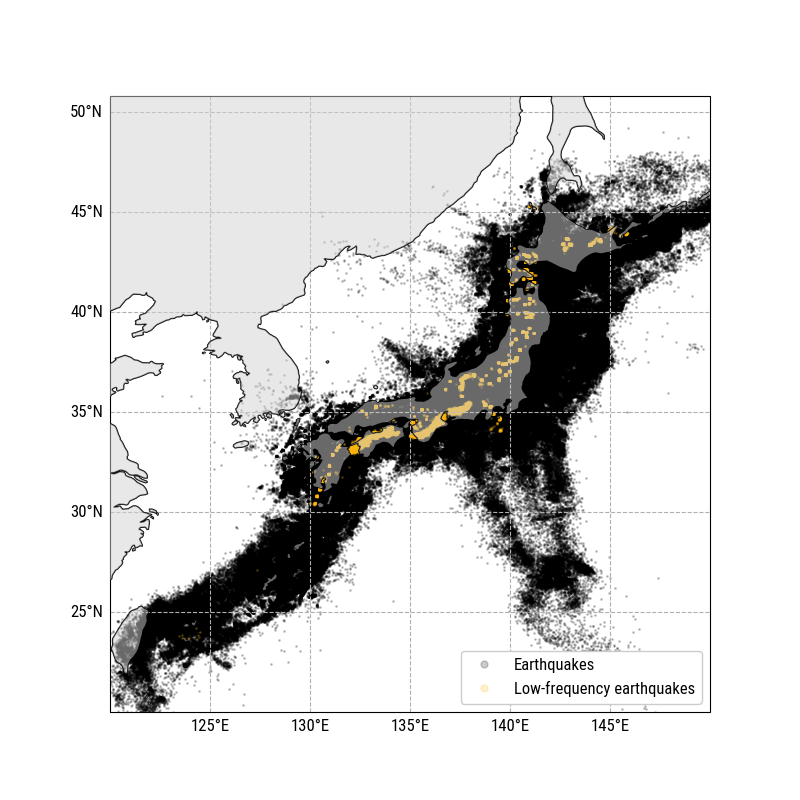

In [11]:
# Map the catalog
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, zorder=10)
ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

ax.plot(eq.lon, eq.lat, 'o', color=to_rgba('k', .2), markersize=1, transform=ccrs.PlateCarree(), label='Earthquakes')
ax.plot(lfe_jma.lon, lfe_jma.lat, 'o', color=to_rgba('C2', .2), markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')


# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

ax.legend(framealpha=1, loc='lower right', markerscale=5)

ax.set_extent([120, 150, 20, 50])

plt.show()

### 2.1.1. <a id='toc2_1_1_'></a>Zoom in Shikoku/Kii/Tokai   [&#128285;](#toc0_)

In [12]:
# # Pick transect points
# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.add_feature(cfeature.COASTLINE, zorder=10)
# ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

# ax.plot(lfe_jma.lon, lfe_jma.lat, 'o', color=to_rgba('C2', .2), markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()

# ax.legend(framealpha=1, loc='lower right', markerscale=5)

# ax.set_extent([131.3, 139.1, 31.25, 36.7])

# picked_locations = []
# # Define the on_click event handler function
# def on_click(event):
#     if event.inaxes == ax:
#         # Get the latitude and longitude of the clicked point
#         lon, lat = event.xdata, event.ydata
#         picked_locations.append((lon, lat))
#         print(f"Point picked: Latitude={lat}, Longitude={lon}")
#         ax.plot([pl[0] for pl in picked_locations], [pl[1] for pl in picked_locations], 'x-', color='r', markersize=10, zorder=11, transform=ccrs.PlateCarree())
#         plt.draw()

# # Connect the on_click event handler to the figure
# fig.canvas.mpl_connect('button_press_event', on_click)

In [13]:
# Save the picked locations
# plt.close('all')

shikoku_transect_line = {'W':{'lon': 131.8283, 'lat': 33.1195}, 'E':{'lon':134.2061, 'lat':34.1385}}
kii_transect_line = {'W':{'lon': 135.1496, 'lat': 33.6479}, 'E':{'lon':136.7599, 'lat':34.75499}}
tokai_transect_line = {'W':{'lon': 136.9864, 'lat': 34.9059}, 'E':{'lon':138.0054, 'lat':35.3462}}

In [14]:
# Project earthquakes and lfes on the transect

# --> shikoku EQ
shikoku_eq_indicator = (eq.lon > shikoku_transect_line['W']['lon']) & (eq.lon < shikoku_transect_line['E']['lon'])
eq_shikoku = eq[shikoku_eq_indicator].copy()
t = transect(eq_shikoku.lon.values, eq_shikoku.lat.values, shikoku_transect_line['W']['lon'], shikoku_transect_line['W']['lat'], shikoku_transect_line['E']['lon'], shikoku_transect_line['E']['lat'])
eq_shikoku['xf'] = t[0]
eq_shikoku['yf'] = t[1]
eq_shikoku = eq_shikoku[abs(eq_shikoku.yf)< 50]

# --> shikoku LFE
shikoku_lfe_indicator = (lfe_jma.lon > shikoku_transect_line['W']['lon']) & (lfe_jma.lon < shikoku_transect_line['E']['lon'])
lfe_shikoku = lfe_jma[shikoku_lfe_indicator].copy()
t = transect(lfe_shikoku.lon.values, lfe_shikoku.lat.values, shikoku_transect_line['W']['lon'], shikoku_transect_line['W']['lat'], shikoku_transect_line['E']['lon'], shikoku_transect_line['E']['lat'])
lfe_shikoku['xf'] = t[0]
lfe_shikoku['yf'] = t[1]
lfe_shikoku = lfe_shikoku[abs(lfe_shikoku.yf)< 50]

# --> kii EQ
kii_eq_indicator = (eq.lon > kii_transect_line['W']['lon']) & (eq.lon < kii_transect_line['E']['lon'])
eq_kii = eq[kii_eq_indicator].copy()
t = transect(eq_kii.lon.values, eq_kii.lat.values, kii_transect_line['W']['lon'], kii_transect_line['W']['lat'], kii_transect_line['E']['lon'], kii_transect_line['E']['lat'])
eq_kii['xf'] = t[0]
eq_kii['yf'] = t[1]
eq_kii = eq_kii[abs(eq_kii.yf)< 50]

# --> kii LFE
kii_lfe_indicator = (lfe_jma.lon > kii_transect_line['W']['lon']) & (lfe_jma.lon < kii_transect_line['E']['lon'])
lfe_kii = lfe_jma[kii_lfe_indicator].copy()
t = transect(lfe_kii.lon.values, lfe_kii.lat.values, kii_transect_line['W']['lon'], kii_transect_line['W']['lat'], kii_transect_line['E']['lon'], kii_transect_line['E']['lat'])
lfe_kii['xf'] = t[0]
lfe_kii['yf'] = t[1]
lfe_kii = lfe_kii[abs(lfe_kii.yf)< 50]

# --> Tokai EQ
tokai_eq_indicator = (eq.lon > tokai_transect_line['W']['lon']) & (eq.lon < tokai_transect_line['E']['lon'])
eq_tokai = eq[tokai_eq_indicator].copy()
t = transect(eq_tokai.lon.values, eq_tokai.lat.values, tokai_transect_line['W']['lon'], tokai_transect_line['W']['lat'], tokai_transect_line['E']['lon'], tokai_transect_line['E']['lat'])
eq_tokai['xf'] = t[0]
eq_tokai['yf'] = t[1]
eq_tokai = eq_tokai[abs(eq_tokai.yf)< 50]

# --> Tokai LFE
tokai_lfe_indicator = (lfe_jma.lon > tokai_transect_line['W']['lon']) & (lfe_jma.lon < tokai_transect_line['E']['lon'])
lfe_tokai = lfe_jma[tokai_lfe_indicator].copy()
t = transect(lfe_tokai.lon.values, lfe_tokai.lat.values, tokai_transect_line['W']['lon'], tokai_transect_line['W']['lat'], tokai_transect_line['E']['lon'], tokai_transect_line['E']['lat'])
lfe_tokai['xf'] = t[0]
lfe_tokai['yf'] = t[1]
lfe_tokai = lfe_tokai[abs(lfe_tokai.yf)< 50]

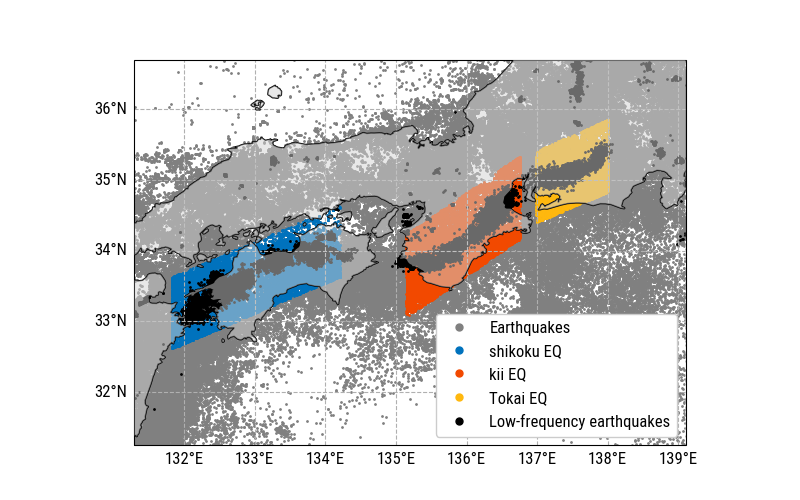

In [15]:
# Check distribution of events
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, zorder=10)
ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

ax.plot(eq.lon, eq.lat, 'o', color=to_rgba('.5', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Earthquakes')

# # For seeing LFEs
# ax.plot(lfe_jma.lon, lfe_jma.lat, 'o', color=to_rgba('C0', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku EQ')
# ax.plot(lfe_shikoku.lon, lfe_shikoku.lat, 'o', color=to_rgba('C0', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku LFE')
# ax.plot(lfe_kii.lon, lfe_kii.lat, 'o', color=to_rgba('C1', 1.), markersize=1, transform=ccrs.PlateCarree(), label='kii LFE')
# ax.plot(lfe_tokai.lon, lfe_tokai.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tokai LFE')

# For seeing EQs
ax.plot(eq_shikoku.lon, eq_shikoku.lat, 'o', color=to_rgba('C0', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku EQ')
ax.plot(eq_kii.lon, eq_kii.lat, 'o', color=to_rgba('C1', 1.), markersize=1, transform=ccrs.PlateCarree(), label='kii EQ')
ax.plot(eq_tokai.lon, eq_tokai.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tokai EQ')
ax.plot(lfe_jma.lon, lfe_jma.lat, 'o', color=to_rgba('k', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

ax.legend(framealpha=1, loc='lower right', markerscale=5)

ax.set_extent([131.3, 139.1, 31.25, 36.7])

plt.show()

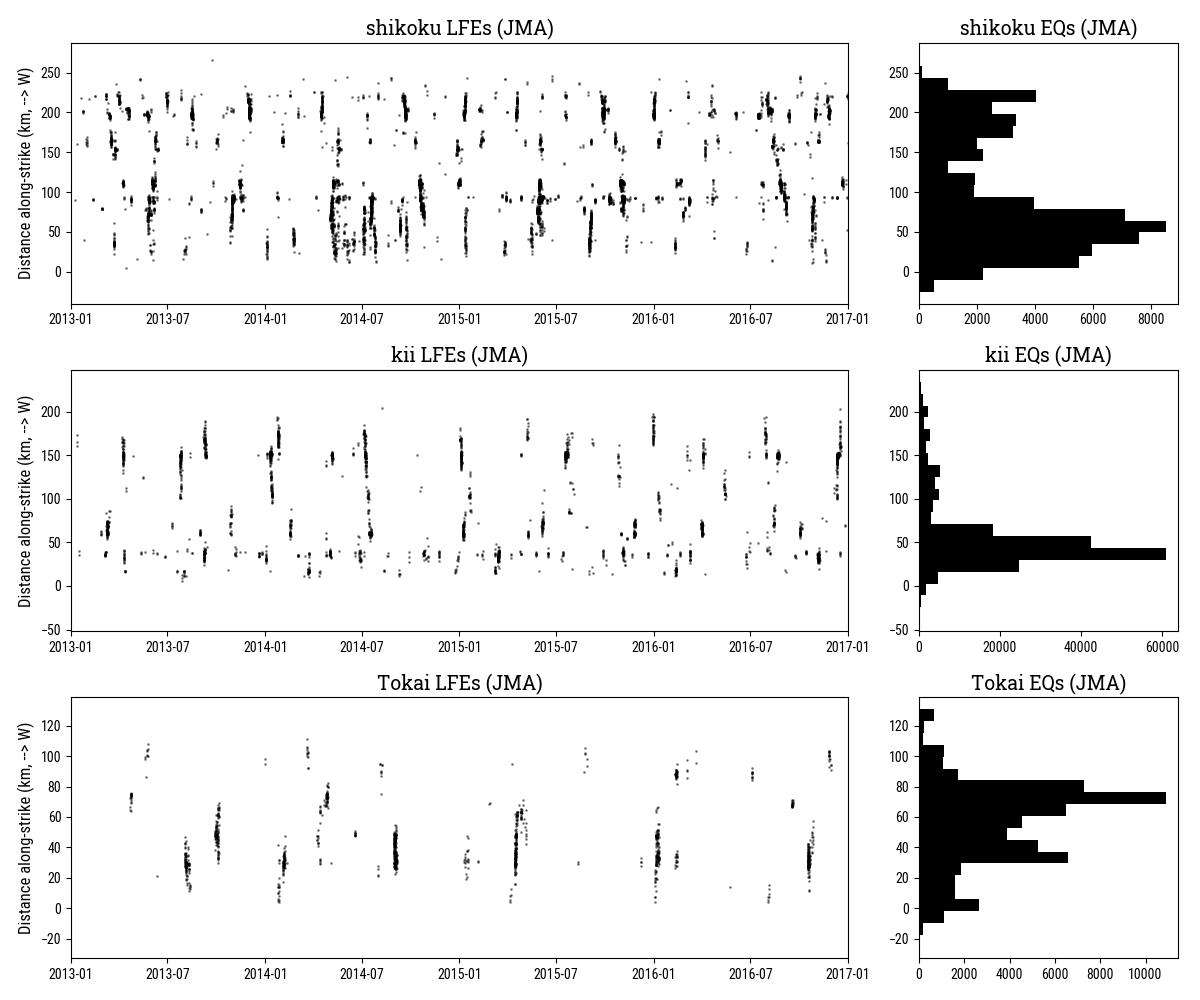

In [16]:
# Show activity
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])

# shikoku
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('shikoku LFEs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.plot(lfe_shikoku.date, lfe_shikoku.xf, 'o', color=to_rgba('k', .4), markersize=1)
ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2017-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
ax.set_title('shikoku EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_shikoku.xf, bins=20, orientation='horizontal', color='k')

# kii
ax = fig.add_subplot(gs[1, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('kii LFEs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.plot(lfe_kii.date, lfe_kii.xf, 'o', color=to_rgba('k', .4), markersize=1)
ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2017-01-01'))

ax = fig.add_subplot(gs[1, 1], sharey=ax)
ax.set_title('kii EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_kii.xf, bins=20, orientation='horizontal', color='k')

# Tokai
ax = fig.add_subplot(gs[2, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('Tokai LFEs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.plot(lfe_tokai.date, lfe_tokai.xf, 'o', color=to_rgba('k', .4), markersize=1)
ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2017-01-01'))

ax = fig.add_subplot(gs[2, 1], sharey=ax)
ax.set_title('Tokai EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_tokai.xf, bins=20, orientation='horizontal', color='k')

plt.tight_layout()
plt.show()

## 2.2. <a id='toc2_2_'></a>World tremor database  [&#128285;](#toc0_)

In [19]:
# Load data
path = workdir + 'projects/data/Catalogs/world_tremor_database/nankai_wtb_0413.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
wtd = pd.read_csv(
    path,
    names=COLS,
)

wtd['date_str'] = wtd.date.values + ' ' + wtd.time.values
wtd['date'] = pd.to_datetime(wtd.date_str)
day0 = np.datetime64('2004-01-01')
wtd['day'] = (wtd.date - day0) / np.timedelta64(1, 'D')

wtd.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(wtd.size, wtd.date.min().year, wtd.date.max().year))

905025 tremor detections, spanning 2004--2013


In [20]:
# Separate shikoku, kii and Tokai
# Project earthquakes and lfes on the transect

# --> shikoku LFE
shikoku_trm_indicator = (wtd.lon > shikoku_transect_line['W']['lon']) & (wtd.lon < shikoku_transect_line['E']['lon'])
trm_shikoku = wtd[shikoku_trm_indicator].copy()
t = transect(trm_shikoku.lon.values, trm_shikoku.lat.values, shikoku_transect_line['W']['lon'], shikoku_transect_line['W']['lat'], shikoku_transect_line['E']['lon'], shikoku_transect_line['E']['lat'])
trm_shikoku['xf'] = t[0]
trm_shikoku['yf'] = t[1]
trm_shikoku = trm_shikoku[abs(trm_shikoku.yf)< 50]

# --> kii LFE
kii_trm_indicator = (wtd.lon > kii_transect_line['W']['lon']) & (wtd.lon < kii_transect_line['E']['lon'])
trm_kii = wtd[kii_trm_indicator].copy()
t = transect(trm_kii.lon.values, trm_kii.lat.values, kii_transect_line['W']['lon'], kii_transect_line['W']['lat'], kii_transect_line['E']['lon'], kii_transect_line['E']['lat'])
trm_kii['xf'] = t[0]
trm_kii['yf'] = t[1]
trm_kii = trm_kii[abs(trm_kii.yf)< 50]

# --> Tokai LFE
tokai_trm_indicator = (wtd.lon > tokai_transect_line['W']['lon']) & (wtd.lon < tokai_transect_line['E']['lon'])
trm_tokai = wtd[tokai_trm_indicator].copy()
t = transect(trm_tokai.lon.values, trm_tokai.lat.values, tokai_transect_line['W']['lon'], tokai_transect_line['W']['lat'], tokai_transect_line['E']['lon'], tokai_transect_line['E']['lat'])
trm_tokai['xf'] = t[0]
trm_tokai['yf'] = t[1]
trm_tokai = trm_tokai[abs(trm_tokai.yf)< 50]

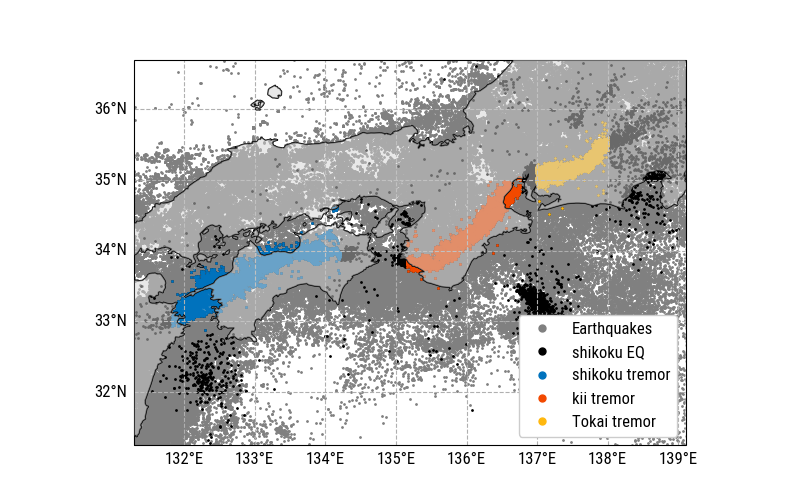

In [21]:
# Check distribution of events
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, zorder=10)
ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

ax.plot(eq.lon, eq.lat, 'o', color=to_rgba('.5', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Earthquakes')

# For seeing LFEs
ax.plot(wtd.lon, wtd.lat, 'o', color=to_rgba('k', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku EQ')
ax.plot(trm_shikoku.lon, trm_shikoku.lat, 'o', color=to_rgba('C0', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku tremor')
ax.plot(trm_kii.lon, trm_kii.lat, 'o', color=to_rgba('C1', 1.), markersize=1, transform=ccrs.PlateCarree(), label='kii tremor')
ax.plot(trm_tokai.lon, trm_tokai.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tokai tremor')

# # For seeing EQs
# ax.plot(eq_shikoku.lon, eq_shikoku.lat, 'o', color=to_rgba('C0', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku EQ')
# ax.plot(eq_kii.lon, eq_kii.lat, 'o', color=to_rgba('C1', 1.), markersize=1, transform=ccrs.PlateCarree(), label='kii EQ')
# ax.plot(eq_tokai.lon, eq_tokai.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tokai EQ')
# ax.plot(wtd.lon, wtd.lat, 'o', color=to_rgba('k', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tremor')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

ax.legend(framealpha=1, loc='lower right', markerscale=5)

ax.set_extent([131.3, 139.1, 31.25, 36.7])

plt.show()

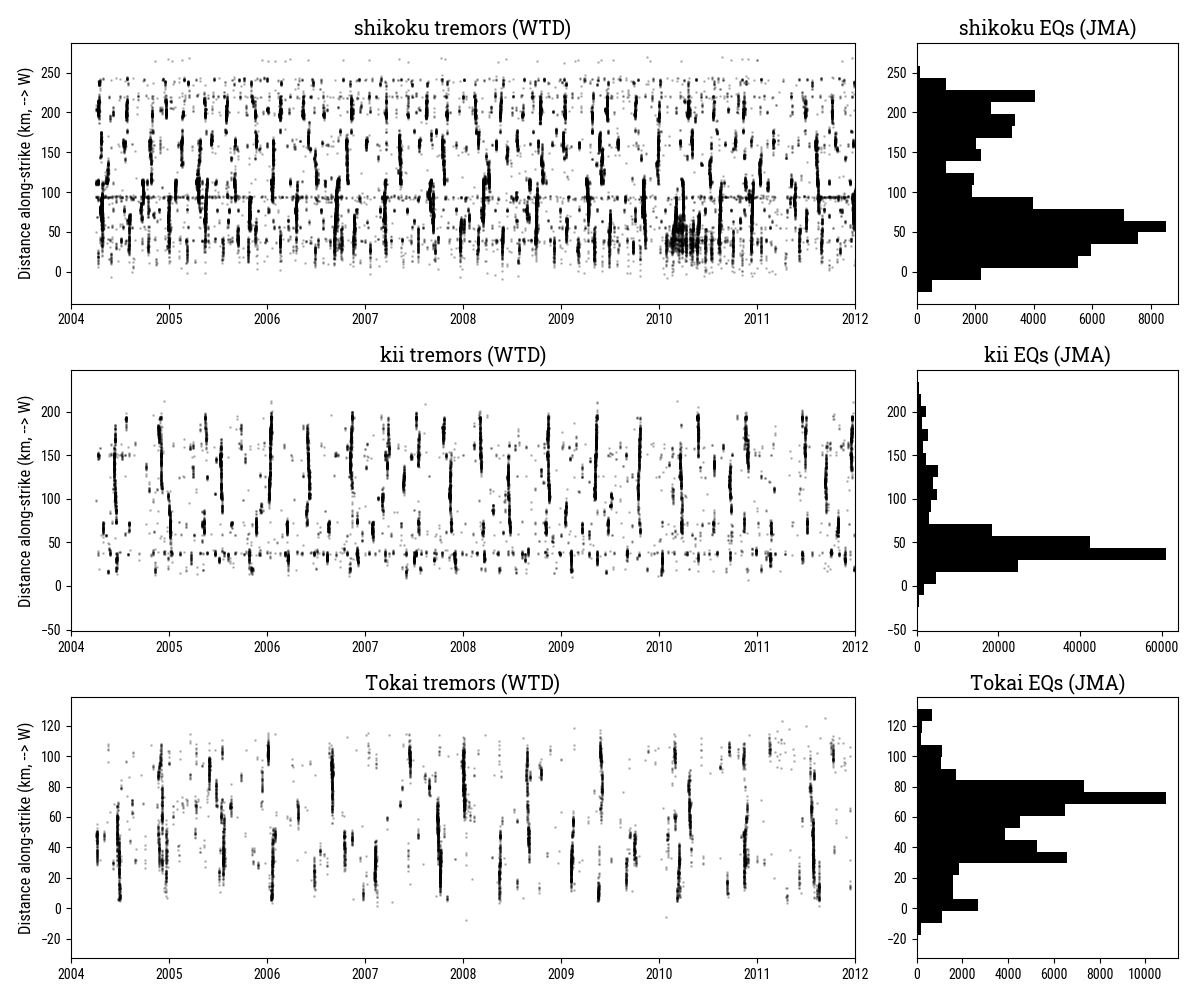

In [22]:
# Show activity
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])

# shikoku
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('shikoku tremors (WTD)', fontsize=14, fontname='Roboto Slab')
ax.plot(trm_shikoku.date, trm_shikoku.xf, 'o', color=to_rgba('k', .2), markersize=1)
ax.set_xlim(np.datetime64('2004-01-01'), np.datetime64('2012-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
ax.set_title('shikoku EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_shikoku.xf, bins=20, orientation='horizontal', color='k')

# kii
ax = fig.add_subplot(gs[1, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('kii tremors (WTD)', fontsize=14, fontname='Roboto Slab')
ax.plot(trm_kii.date, trm_kii.xf, 'o', color=to_rgba('k', .2), markersize=1)
ax.set_xlim(np.datetime64('2004-01-01'), np.datetime64('2012-01-01'))

ax = fig.add_subplot(gs[1, 1], sharey=ax)
ax.set_title('kii EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_kii.xf, bins=20, orientation='horizontal', color='k')

# Tokai
ax = fig.add_subplot(gs[2, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('Tokai tremors (WTD)', fontsize=14, fontname='Roboto Slab')
ax.plot(trm_tokai.date, trm_tokai.xf, 'o', color=to_rgba('k', .2), markersize=1)
ax.set_xlim(np.datetime64('2004-01-01'), np.datetime64('2012-01-01'))

ax = fig.add_subplot(gs[2, 1], sharey=ax)
ax.set_title('Tokai EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_tokai.xf, bins=20, orientation='horizontal', color='k')

plt.tight_layout()
plt.show()

## 2.3. <a id='toc2_3_'></a>Shikoku LFEs [&#128285;](#toc0_)

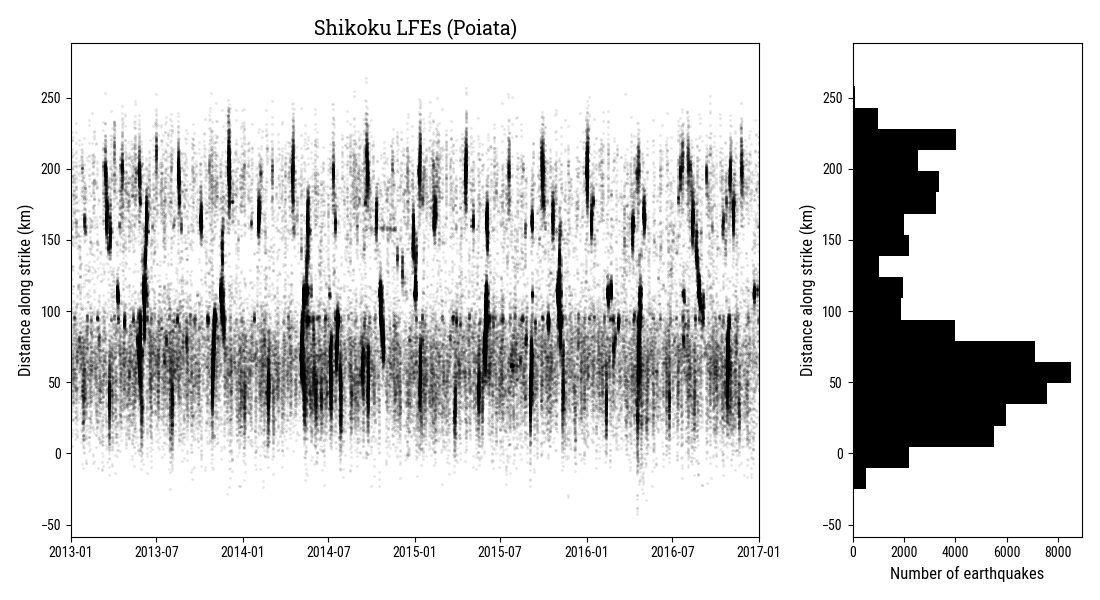

In [23]:
# Load data
CAT_PATH = workdir + 'projects/data/Catalogs/japan_lfe_poiata21/LFEautoWCshikoku2013-2016_JGR.txt'
COL_NAMES = [ "ev_id", "date", "lat", "lon", "depth", "co_st"]
shk = pd.read_csv(
    CAT_PATH,
    names=COL_NAMES,
    delim_whitespace=True,
    index_col=False,
    )

shk["date"] = pd.to_datetime(shk["date"], utc=False).dt.tz_localize(None)
day0 = np.datetime64('2013-01-01')
shk['day'] = (shk.date - day0) / np.timedelta64(1, 'D')

t = transect(shk.lon.values, shk.lat.values, shikoku_transect_line['W']['lon'], shikoku_transect_line['W']['lat'], shikoku_transect_line['E']['lon'], shikoku_transect_line['E']['lat'])
shk['xf'] = t[0]
shk['yf'] = t[1]

# Plot
fig = plt.figure(figsize=(11, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])

ax = fig.add_subplot(gs[0])
ax.set_title('Shikoku LFEs (Poiata)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along strike (km)')

ax.plot(shk.date, shk.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .1), ms=2)

ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2017-01-01'))

ax = fig.add_subplot(gs[1], sharey=ax)
ax.hist(eq_shikoku.xf, bins=20, orientation='horizontal', color='k')
ax.set_xlabel('Number of earthquakes')
ax.set_ylabel('Distance along strike (km)')

plt.tight_layout()
plt.show()